**Taller #2**

**Nota:** El archivo esta hecho para correrse de manera secuencial, debido a que las celdas utilizan funcionas y variables de celdas anteriores. Para correcto funcionamiento, correr todas las celdas anteriores a la que se desee probar.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats as stats

Punto 1

In [3]:
#CARGA DE DATOS

dict_data = {"year":[], "month":[], "day":[], "SSN":[]}
counter = 0
temp_list = None

with open("list_aavso-arssn_daily.txt") as data:
    while True:
        line = data.readline()
        if counter > 1:
            temp_list = line.split()
            dict_data["year"].append(float(temp_list[0]))
            dict_data["month"].append(float(temp_list[1]))
            dict_data["day"].append(float(temp_list[2]))
            dict_data["SSN"].append(float(temp_list[3]))
        if temp_list == ['2012', '1', '1', '39']:
            break
        counter += 1

*1.1*

In [41]:
#Creando un nuevo diccionario sin SSN:
datos_fechas = dict_data.copy()
datos_fechas.pop("SSN")

#Pasando al formato to_datetime
formated_data = pd.to_datetime(datos_fechas)

#Sacando la transformada de Fourier
transformada = np.fft.fft(dict_data["SSN"] - np.mean((dict_data)["SSN"]))

#Sacando la cantidad de muestras por año a travez de la moda de las muestras
anios = {}
for i in dict_data["year"]:
    if str(i) not in anios:
        anios[f"{i}"] = dict_data["year"].count(i)
sample_frecuency = stats.mode([anios[x] for x in anios.keys()])[0]

#Sacando la frecuencia del sistema
freq = np.fft.fftfreq(len(dict_data["SSN"]), d=1/sample_frecuency)
magnitudes = np.abs(transformada)
freq_positivas = freq[:len(freq) // 2]
magnitudes_positivas = magnitudes[:len(magnitudes) // 2]
frecuencia_principal = freq_positivas[list(magnitudes_positivas).index(np.max(magnitudes_positivas))]

print(f"El periodo de la señal es de: {round(1/frecuencia_principal, 2)} años")

El periodo de la señal es de: 11.17 años


*1.2*

c:\Users\PEPE\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\PEPE\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


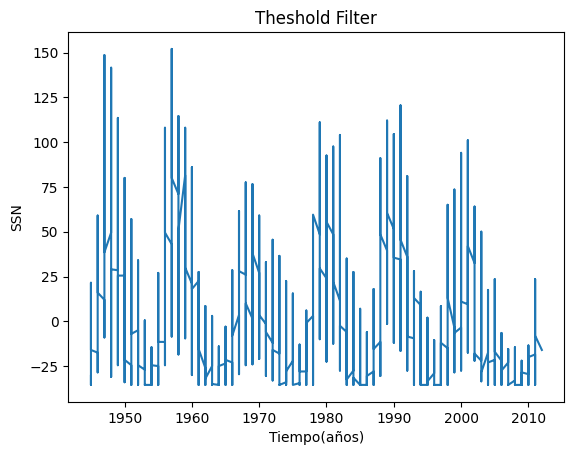

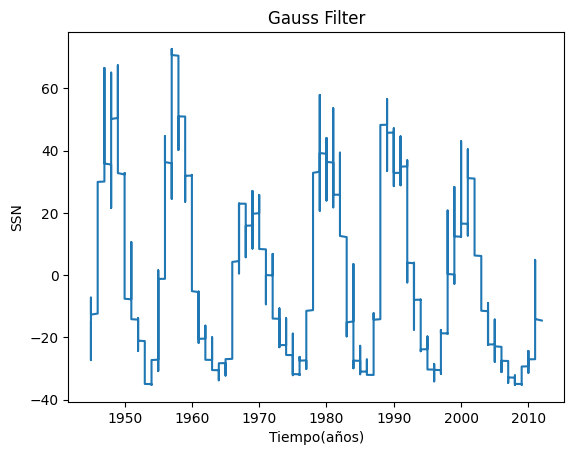

Claramente, el filtro de Gauss es mucho mejor para este caso, puesto que el tipo Threshold nos da un resultado con transiciones muy abruptas, lo que hace que se pierda el sentido físico de los datos a la vista.


In [46]:
#Utilizando los resultados del ejercicio anterior:

#Filtro threshold
freq_corte = frecuencia_principal
filtro = transformada
filtro[np.abs(freq) > freq] = 0
senal_filtrada = np.fft.ifft(filtro)

#Filtro Gauss
gamma = freq_corte / np.sqrt(2*np.log(2))
filtro_gauss = np.exp(-(freq**2)*(gamma))
senal_filtrada_gauss = np.fft.ifft(transformada * filtro_gauss)

plt.plot(dict_data["year"], senal_filtrada)
plt.title("Theshold Filter")
plt.xlabel("Tiempo(años)")
plt.ylabel("SSN")
plt.show()
plt.plot(dict_data["year"], senal_filtrada_gauss)
plt.title("Gauss Filter")
plt.xlabel("Tiempo(años)")
plt.ylabel("SSN")
plt.show()
print("Claramente, el filtro de Gauss es mucho mejor para este caso, puesto que el tipo Threshold nos da un resultado con transiciones muy abruptas, lo que hace que se pierda el sentido físico de los datos a la vista.")

C:\Users\PEPE\AppData\Local\Temp\ipykernel_19680\769273655.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot( np.log10(freq_positivas), np.log10(magnitudes_positivas))


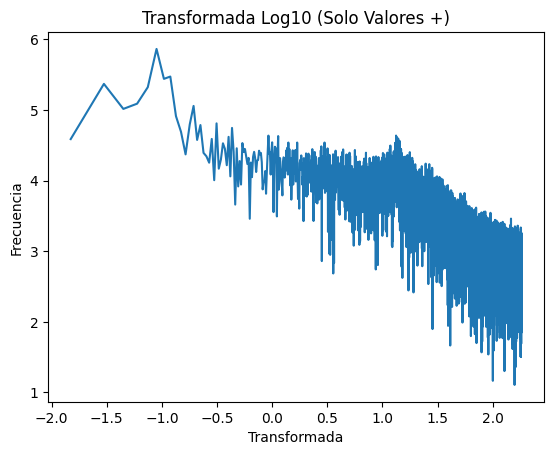

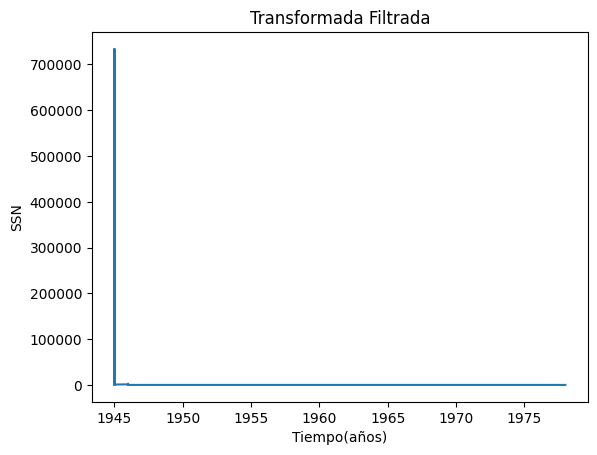

In [63]:
#1.2 a)
plt.plot( np.log10(freq_positivas), np.log10(magnitudes_positivas))
plt.title("Transformada Log10 (Solo Valores +)")
plt.xlabel("Transformada")
plt.ylabel("Frecuencia")
plt.show()
plt.plot(dict_data["year"][:len(dict_data["year"]) // 2], (magnitudes_positivas * filtro_gauss[:len(freq) // 2]))
plt.title("Transformada Filtrada")
plt.xlabel("Tiempo(años)")
plt.ylabel("SSN")
plt.show()

In [ ]:
#1.2 b)

*1.3*